This notebook is a loose re-implementation of some of the work listed in the paper

In [33]:
# imports
import torch
import numpy
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict
import tqdm

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def imshow(inp, title=None,
          mean=numpy.array([0.485, 0.456, 0.406]),
          std=numpy.array([0.229, 0.224, 0.225])):
    """Show torch tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [3]:
# Get model
model = models.resnet18(pretrained=True)

Files already downloaded and verified
Files already downloaded and verified


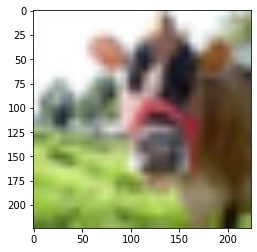

In [6]:
# Get dataset
train_dataset = datasets.CIFAR100('/data/cifar100/', train=True, download=True,
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8,
            num_workers=2)

test_dataset = datasets.CIFAR100('/data/cifar100/', train=False, download=True,
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
            num_workers=2)

imshow(train_dataset[0][0])

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
for n,m in model.named_modules():
    print(n)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


In [17]:
class IntermediateReps(torch.nn.Module):
    
    def __init__(self, model, intermediate_layers):
        super(IntermediateReps, self).__init__()
        self.model = model
        self.intermediate_layers = intermediate_layers
        self._features = {layer: torch.empty(0) for layer in intermediate_layers}
        self.handles = []
        
        for layer_id in self.intermediate_layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            self.handles.append(
                layer.register_forward_hook(self.save_outputs_hook(layer_id))
            )

    def save_outputs_hook(self, layer_id: str):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x):
        _ = self.model(x)
        return self._features
    
    def remove_handles(self):
        for h in self.handles:
            h.remove()
        self.handles = []

In [19]:
model = IntermediateReps(
    models.resnet18(pretrained=True),
    [
        'bn1',
        'layer1.0.bn1',
        'layer1.0.bn2',
        'layer1.1.bn1',
        'layer1.1.bn2',
        'layer2.0.bn1',
        'layer2.0.bn2',
        'layer2.1.bn1',
        'layer2.1.bn2',
        'layer3.0.bn1',
        'layer3.0.bn2',
        'layer3.1.bn1',
        'layer3.1.bn2',
        'layer4.0.bn1',
        'layer4.0.bn2',
        'layer4.1.bn1',
        'layer4.1.bn2',
        'fc'
    ]
)

In [35]:
all_features = defaultdict(list)
model = model.eval().to(device)
with torch.no_grad():
    for data, label in tqdm.tqdm(trainloader):
        data = data.to(device)
        features = model(data)
        for k,v in features.items():
            all_features[k].append(torch.flatten(v, start_dim=1).cpu().numpy())

  0%|          | 26/6250 [01:17<5:07:37,  2.97s/it] 


KeyboardInterrupt: 